*Copyright: Fanny Lehmann (fanny.lehmann@centralesupelec.fr)* <br>
*June, 2023*

In [2]:
import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import simulation.randomfields as rf
from simulation.utils import *
from globalvars import *

PATH_SEM3D = '/home/lehmannf/SEM2021/' # path to your personal installation of SEM3D

In [3]:
run_name = 'example'
path_folder = './simulation/' + run_name # folder to write all the simulation files

This notebook details all the steps needed to write the input files to run a simulation in a cubic domain with several horizontal layers, and random fields in each layer. 

Notebook summary:
1. [Write the mesh files](#section1)
2. [Create the mesh](#section2)
3. [Add random fluctuations to the material](#Section3)
4. [Assemble random materials into a numpy array](#Section4)
5. [Run the simulation](#Section5)

**This notebook assumes that you have already installed SEM3D and its RandomField module from [github](https://github.com/sem3d/SEM)**

<a id='section1'></a>
# 1. Write the mesh files

**After running this section, you should have the following files:**
- `mater.in`
- `mat.dat`
- `mesh.input`
- `input.spec`

Choose between 1 and 6 layers (does not include the constant bottom layer).

In [4]:
nb_layers = np.random.randint(1, high=7) # does not count the constant bottom layer
print(nb_layers)

4


Choose the thickness of each layer by assigning one layer index to each of the 26 vertical points (`temp`). Then, count the number of points inside each layer to determine their respective thickness. There may be empty layers but that is not a problem

In [6]:
temp = np.random.randint(nb_layers, size=26)
thickness_steps = np.unique(temp, return_counts=True)[1]

Assign a random shear-wave velocity (S-wave velocity `Vs`) value to each layer. All layers are solid (`S`). The other material properties are : 
- compressional wave velocity (P-wave velocity, `Vp`)
- density (`Rho`)
- attenuation factors for P- and S-waves (`Qk` and `Qmu`)
They are all computed from the S-wave velocity. 

In [7]:
layers = pd.DataFrame({'thickness':np.append(thickness_steps*DX, DEPTH_BOTTOM),
                    'type':['S']*(thickness_steps.shape[0]+1),
                    'Vs':np.append(1785 + (3214 - 1785) * np.random.rand(nb_layers), VS_MAX),
                    })
layers.loc[:,'Vp'] = layers.loc[:,'Vs']*1.7
layers.loc[:,'Rho'] = ComputeDsfromCp(layers.Vp)
layers.loc[:,'Qk'] = ComputeQpfromCpCs(layers.Vp, layers.Vs)
layers.loc[:,'Qmu'] = ComputeQsfromCs(layers.Vs)
layers.loc[:,'steps'] = np.append(thickness_steps, 6) # number of mesh layers
layers = layers.astype({'thickness':'int','Qk':'int','Qmu':'int','Rho':'int','steps':'int'})

layers

,thickness,type,Vs,Vp,Rho,Qk,Qmu,steps
0,1800,S,2846.003763,4838.206398,2510,569,284,6
1,3300,S,2587.867988,4399.375580,2448,517,258,11
2,1800,S,2351.558291,3997.649094,2393,470,235,6
3,900,S,1959.872618,3331.783451,2289,391,195,3
4,1800,S,4500.000000,7650.000000,3170,900,450,6


Write the file describing the mesh. The spatial bounds (`XMIN`, `XMAX`, `YMIN`, `YMAX`, `ZMAX`) are given in meters and defined in `globalvars.py`. 

To simulate a semi-infinite domain, we put absorbing layers on all domain faces excepting the surface one. This behaviour is described by the booleans `PML_sides`, `PML_top`, and `PML_bottom` saying if absorbing boundary is present on the corresponding face or not (PML stands for Perfectly Matched Layer). The number of absorbing layers is given by `PML_layers`. Usually, one PML layer is enough. 

In [8]:
PML_sides = True
PML_top = False
PML_bottom = True
PML_layers = 1
    
domain = [XMIN, XMAX, DX, YMIN, YMAX, DY, ZMAX]
comments=['xmin','xmax','xstep','ymin','ymax','ystep','zmax']

# write the physical bounds
with open(path_folder+'mat.dat', 'w') as f:
    for line, comment in zip(domain,comments):
        f.write(f"{line}\t# {comment}\n")
    f.write(f"{layers.shape[0]}\t# nb. of layers\n")

# write the layers
with open(path_folder+'mat.dat', 'a') as f:
    for index,row in layers.iterrows():
        f.write(f"{int(row.loc['thickness'])} {int(row.loc['steps'])}\t# layer {index} (thickness, number of vertical elements)\n")

# write the PMLs
with open(path_folder+'mat.dat', 'a') as f:
    f.write(f"{PML_layers}\t# Number of PML layers (0=no PML)\n")
    f.write('2 ')
    f.write('1 ' if PML_top else '0 ')
    f.write('1 ' if PML_bottom else '0 ')
    f.write('1 1 1 1 ' if PML_sides else '0 0 0 0 ')
    f.write('\t# PMLs on up down north south east west\n')
    f.write('1\t# 8 or 27 control points for elements (1:8, 2:27)\n')

Describe the material properties

In [9]:
with open(path_folder+'mater.in', 'w') as f:
    f.write(f"{layers.shape[0]}\t# number of layers\n")

    for index,row in layers.iterrows():
        f.write(f"{row.type}\t{row.Vp}\t{row.Vs}\t{row.Rho}\t{row.Qk}\t{row.Qmu}\n")
    f.write('# Material type, Vp, Vs, Rho, Qk, Qmu')

Write the general configuration file

In [10]:
with open(path_folder+'input.spec', 'w') as f:
    f.write('# -*- mode: perl -*-\n')
    f.write(f'run_name = "{run_name}";\n\n')
    f.write('mesh_file = "mesh4spec"; # input mesh file\n')
    f.write('mat_file = "material.input";\n')
    f.write('dim=3;\n')
    f.write(f'ngll={NGLL};\n\n') # number of GLL quadrature points

# damping
if np.nanmax(layers[['Qk','Qmu']])==0:
    Nsolids=0
else:
    Nsolids=3

with open(path_folder+'input.spec', 'a') as f:
    f.write('amortissement {\n')
    f.write(f'\tnsolids = {Nsolids};')
    f.write('\t# number of solids for attenuation (0 if no attenuation)\n')
    f.write('\tatn_band = 10  0.05;\t# attenuation period band\n')
    f.write('\tatn_period = 0.2;\t# model period\n')
    f.write('};\n\n')

<a id='section2'></a>
# 2. Create the mesh

In `SEM3D` code, there is a single function to create the mesh and partition it over processors. The file `mesh.input` gives the number of processors to partition the mesh. This must be equal to the number of processors used to run the simulation later. 

In [11]:
Nprocessors = 1
with open(path_folder+'/mesh.input', 'w') as f:
    f.write(f'{Nprocessors}\t# number of processors\n')
    f.write('1\t# type of mesh: 1 = on the fly\n')

The command line to create the mesh in `SEM_BUILD/MESH/mesher < mesh.input`. It can be executed from the terminal, in a bash file on a computing cluster, or directly in the notebook for small computation. 

In [12]:
current_dir = os.getcwd()
os.chdir(path_folder)

output = os.system(PATH_SEM3D + 'SEM_BUILD/MESH/mesher < mesh.input')
if output!=0:
    os.chdir(current_dir)
    raise Exception('The mesher could not run "'+run_name+'"')

os.chdir(current_dir)

-------------------------------------------------
-------------------------------------------------
-----                                       -----
----- Construction of input files for SEM3D -----
-----                                       -----
-------------------------------------------------
-------------------------------------------------

    DEBUG MODE    


   --> How many procs for the run ?
             1 processor(s)
 

  --> Which Initial Mesh?
      1- On the fly
      2- Abaqus from Cubit
      3- Ideas (.unv) files
      4- HDF5 Hex8 files
      5- Earth Chunk
      6- Full earth
            Your choice is 1 
 

Configuration SEM
Schema en acceleration: 0
Schema en vitesse: 0
Duree simulation: 0.000000
Newmark: alpha=0.000000 beta=0.000000 gamma=0.000000
Fichier maillage: 'mesh4spec'
Modele : 0
Anisotropy : 0
Fichier materiau: 'material.input'
Sauv. Traces : 0
Sauv. Snap   : 0
Fichier stations: '(null)'
Snap interval : 0.000000
Snap selection : (nil)
out variables : 

Move all mesher files (starting by `mesh4spec`) into a folder called `sem` (do not change the name of this folder). 

In [13]:
current_dir = os.getcwd()
os.chdir(path_folder)

if not 'sem' in os.listdir():
    os.mkdir('sem')
    
output = os.system('mv mesh4spec* sem')
    
os.chdir(current_dir)

<a id='section3'></a>
# 3. Add random fluctuations to the material

Randomly choose the correlation lengths along x, y, and z directions. Choose the coefficient of variation according to a normal distribution and ensure a positive value. Parameters are different in each layer. 

In [14]:
Nrandom_layers = layers.shape[0]-1 # all layers except the bottom one have fluctuations
random_layers = np.arange(Nrandom_layers) # indices of random layers
corr_length_x = np.random.choice([1500, 3000, 4500, 6000], size = Nrandom_layers)
corr_length_y = np.random.choice([1500, 3000, 4500, 6000], size = Nrandom_layers)
corr_length_z = np.random.choice([1500, 3000, 4500, 6000], size = Nrandom_layers)

print(f'Chosen correlation length for x: {corr_length_x}, y: {corr_length_y}, z: {corr_length_z}')
coef_var = np.abs(np.random.randn(Nrandom_layers)*0.1+0.2) # N(0.2, 0.1)
print(f'Chosen coefficient of variation: {coef_var}')

Chosen correlation length for x: [6000 1500 3000 1500], y: [4500 4500 1500 3000], z: [6000 1500 3000 6000]
Chosen coefficient of variation: [0.26237449 0.19625083 0.22894829 0.09916773]


The random generator is different for each layer. It is initialized at the beginning and incremented for each layer. 

In [15]:
seed = np.random.randint(0, 1e5) 

Assign random properties to Vs.

In [16]:
correlation_mode = 3 # 1= Gaussian, 2=Exponential, 3=Von Karman
marginal = 2 # 1 = Gaussian, 2 = LogNormal

with open(path_folder+'random.spec', 'w') as f:
    f.write('# Number of random materials\n')
    f.write(f'{Nrandom_layers}\n')

    for l, cv, cx, cy, cz in zip(random_layers, coef_var, corr_length_x, corr_length_y, corr_length_z):
        f.write('# Material number\n')
        f.write(f'{l}\n')
        f.write('# Vp_Vs_Rho_flag: Calculate Lambda, Kappa, Mu and Density average from Vp Vs Density (0 = false, 1 = true) \n')
        f.write('# If previous option = 1, give Vp, Vs and Density on the same line \n')
        f.write(f"0\t{layers.loc[l,'Vp']}\t{layers.loc[l,'Vs']}\t{layers.loc[l,'Rho']}\n")
        f.write('# Number of properties\n')
        f.write(f"1 \n")
        f.write('# Property_Name\tavg\tcorrMod\tcorrL_x\tcorrL_y\tcorrL_z\tmargiF\tCV\tseedStart\n')
        
        f.write(f'"Vs"\t{layers.loc[l,"Vs"]}\t{correlation_mode}\t')
        f.write(f'{cx}\t{cy}\t{cz}\t{marginal}\t{cv}\t{seed}\n')
        
        seed += 1

The random field computation is very light, it can be run on a local computer. 

In [17]:
current_dir = os.getcwd()
os.chdir(path_folder)

# remove the homogeneous materials created by the mesher
if 'mat' in os.listdir():
    shutil.rmtree('mat')

output = os.system(PATH_SEM3D + 'BUILD_RF/randomField.exe')
if output!=0:
    os.chdir(current_dir)
    raise Exception('RandomField could not run "'+run_name+'"')
    
os.chdir(current_dir)

 IPT_Temp%rang =            0

 ****************************************************************************
 ****************************************************************************
 ****************************************************************************
 ************************                             ***********************
 ************************  RANDOM FIELD LIBRARY TEST  ***********************
 ************************                             ***********************
 ****************************************************************************
 ****************************************************************************
 ****************************************************************************

 -> MPI_communications started
          running on: 
/home/lehmannf/Documents/collaborations/HEMEW3D/simulation
          nb_procs    =            1
          outputStyle =            1
 -> Reading inputs
      -> Reading Main Input
       ./random.spec exist?  T
 

<a id='section4'></a>
# 4. Assemble random materials into a numpy array

Read the material values from the `h5` files and store them into a dataframe `df`. 

In [18]:
df = read_random_field('Vs', 0, min_field = DX*FMAX,
                          Xinterp=DX, Yinterp=DY, Zinterp=DZ,
                          interpolation=True, path_case=path_folder)

for material in range(1, layers.shape[0]-1):
    temp = read_random_field('Vs', material, min_field = DX*FMAX,
                          Xinterp=DX, Yinterp=DY, Zinterp=DZ,
                          interpolation=True, path_case=path_folder)
    df = pd.concat([df, temp])
    

# Since RandomField extends the domain, we need to restrict to the inner domain.
df = df.loc[(df.x>=XMIN)&(df.x<=XMAX)&(df.y>=YMIN)&(df.y<=YMAX)&(df.z>=-DEPTH_TOTAL+DEPTH_BOTTOM)&(df.z<=ZMAX)]

# create the constant bottom layer
Xtemp = np.unique(df.x)
Ytemp = np.unique(df.y)
Ztemp = np.linspace(-DEPTH_TOTAL, -DEPTH_TOTAL+DEPTH_BOTTOM, int(DEPTH_BOTTOM/DZ)+1)
temp = array2dataframe(layers.iloc[-1].loc['Vs']*np.ones((Xtemp.shape[0],Ytemp.shape[0],Ztemp.shape[0])),
                        Xtemp, Ytemp, Ztemp, 'Vs', order='xyz')
df = pd.concat([df, temp])

At the interface between two layers, there are values from both random fields. In this case, the mean value is kept.

In [19]:
temp = df.groupby(['x','y','z']).mean()
df_unique = pd.DataFrame({'x':temp.index.get_level_values('x'),
                          'y':temp.index.get_level_values('y'),
                          'z':temp.index.get_level_values('z'),
                          'Vs':temp.Vs.values})

Convert the dataframe back to a 3D matrix. 

In [20]:
mat = dataframe2array(df_unique, 'Vs', order='xyz')

Restrict to the acceptable physical values `VS_MIN` and `VS_MAX`

In [21]:
mat = np.where(mat<VS_MIN, VS_MIN, np.where(mat>VS_MAX, VS_MAX, mat))

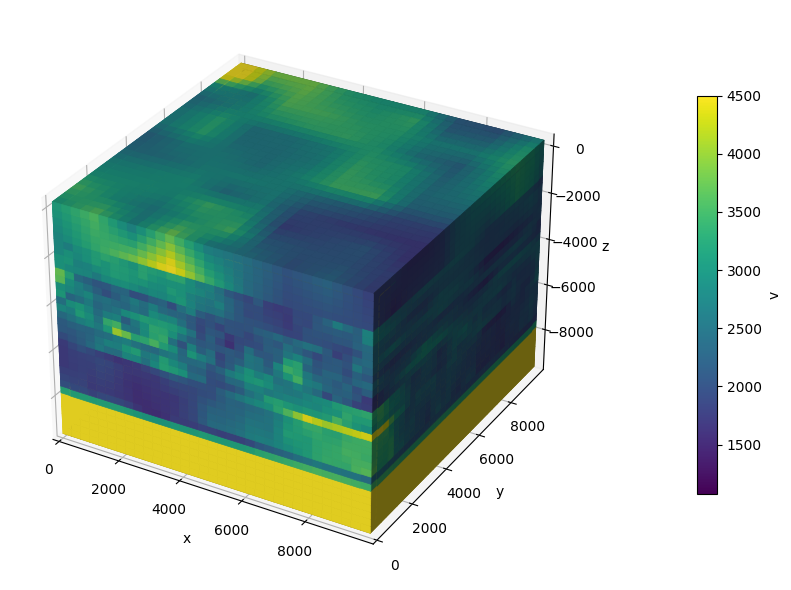

In [22]:
plot3Dcube(mat,
           np.linspace(XMIN, XMAX, int((XMAX-XMIN)/DX)+1),
           np.linspace(YMIN, YMAX, int((YMAX-YMIN)/DY)+1),
           np.linspace(-DEPTH_TOTAL, ZMAX, int((ZMAX+DEPTH_TOTAL)/DZ)+1),
           vmin = VS_MIN, vmax=VS_MAX)

<a id='section5'></a>
# 5. Run the simulation

In [23]:
from simulation.simulation_files import *

Define the source as a double-couple moment tensor. 

In [24]:
strike = 48
dip = 45
rake = 88
M0 = 2.47e16
Mxx, Myy, Mzz, Mxy, Mxz, Myz = compute_moment_tensor(strike,dip,rake,M0)

Define the source position at the center of the domain and in the constant bottom layer. 

In [25]:
source_x = XMIN + (XMAX-XMIN)/2
source_y = YMIN + (YMAX - YMIN)/2
source_z = ZMAX - 28*DZ
print(f'Source is located at ({source_x}, {source_y}, {source_z})')

source=pd.Series({'type':'moment',
                 'x':source_x,
                 'y':source_y,
                 'z':source_y,
                 'moment_xx':Mxx,
                 'moment_yy':Myy,
                 'moment_zz':Mzz,
                 'moment_xy':Mxy,
                 'moment_xz':Mxz,
                 'moment_yz':Myz,
                 'func' : 'file',
                  'filename' : f'{path_folder}source_time.txt',
                 })

Source is located at (4800.0, 4800.0, -8400)


Define the source time function as a ramp function parametrized by the magnitude `Mw`.

In [26]:
t_final = 20
dt = 0.001 # sampling time step for the source
t0 = 0.5 # initial time of the source
Mw = 4.9 # magntiude
tau = 10**(0.5*(Mw-6.69)) # formula depending on Mw 

tvec = np.arange(0, t_final + dt,dt) 
source_tf = pd.Series(np.where(tvec>=t0, spice_bench(tvec-t0, 1/tau), 0), index=tvec,dtype=float)

# write the source time file
with open(path_folder + 'source_time.txt', 'w') as f:
    for t,s in zip(source_tf.index, source_tf.values):
        f.write(f'{t} {s}\n')

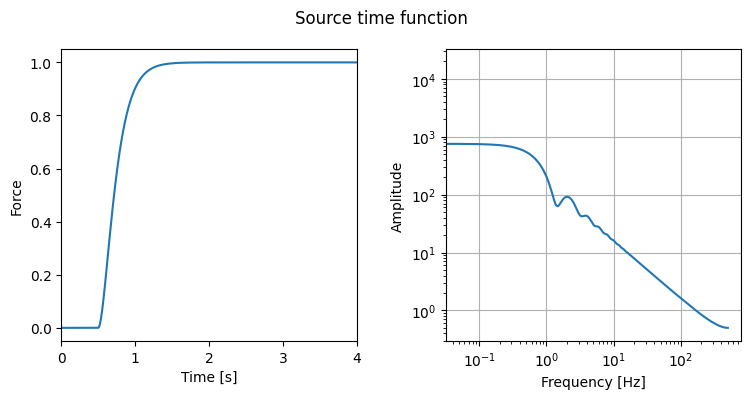

In [27]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(8,4))
ax1.plot(source_tf)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Force')
ax1.set_xlim([0,4])

ax2.loglog(np.fft.rfftfreq(source_tf.shape[0],d=dt),np.abs(np.fft.rfft(source_tf)))
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude')
ax2.grid(True)
fig.suptitle('Source time function')
fig.subplots_adjust(left=0.1,right=0.95,wspace=0.3, bottom=0.15)
plt.show()

All simulation inputs are included in the `input.spec` file.

In [28]:
with open(path_folder+'input.spec', 'a') as f:
    f.write('# duration of the run\n')
    f.write(f'sim_time = {t_final};\n\n')

Write the source parameters

In [29]:
with open(path_folder+'input.spec', 'a') as f:
    f.write('# Introduce a source\n')       
    f.write('source {\n')
    f.write('\t# coordinates of the source (x,yz) or (lat,long,R)\n')
    f.write(f'\tcoords = {source.x} {source.y} {source.z};\n')
    f.write('\t# type (1: impulse, 2: moment tensor, 3: fluidpulse)\n')
    f.write(f'\ttype = {source.type};\n')

    if source.func=='file':
        f.write(f'\ttime_file = "{source.filename}.txt";\n')

    if 'dir_x' in source.index:
        f.write('\t#direction (only for impulse)\n')
        f.write(f'\tdir = {source.dir_x} {source.dir_y} {source.dir_z};\n')

    if 'moment_xx' in source.index:
        f.write('\t# moment (xx yy zz xy xz yz)\n')
        f.write(f'\tmoment = {source.moment_xx} {source.moment_yy} '\
                f'{source.moment_zz} {source.moment_xy} {source.moment_xz} {source.moment_yz};\n')
        
    for key in ['func','freq','tau','gamma','ts']:
        if key in source.index:
            f.write('\t{} = {};\n'.format(key,source.loc[key]))

    f.write('};\n\n')

Define a regular grid of sensors at the surface.

In [30]:
sensors = pd.DataFrame(columns=['x','y','z'])

for x in np.linspace(XMIN + DX/2, XMAX-DX/2, 16):
    for y in np.linspace(YMIN + DY/2, YMAX-DY/2, 16):
        sensors = pd.concat([sensors, pd.DataFrame(np.array([[x, y , ZMAX-1]]),
                                                        columns=['x','y','z'])])
        
sensors.to_csv(path_folder+'sensors.txt', index=None, header=None, sep=' ')

Write the sensors description in the `input.spec` file.

In [31]:
with open(path_folder+'input.spec', 'a') as f:
    f.writelines(['# Sensors description\n',
                  'save_traces = true;\n',
                  'traces_format = hdf5;\n\n'])
    
with open(path_folder+'input.spec', 'a') as f:
    f.write('capteurs "S" {\n')
    f.write('\ttype = points;\n')
    f.write(f'\tfile = "sensors.txt";\n')
    f.write(f'\tperiod = 5;\n') # solutions are synthetized every period internal time step
    f.write('};\n\n') 

Supplementary parameters for the simulation

In [32]:
with open(path_folder+'input.spec', 'a') as f:
    f.write('snapshots {\n')
    f.write('\tsave_snap = false;\n')
    f.write('\tsnap_interval = 0.1;\n')
    f.write('\tselect all;\n')
    f.write('};\n\n')
    
with open(path_folder+'input.spec', 'a') as f:
    f.write('# Fichier protection reprise\n')
    f.write('prorep=false;\n')
    f.write('prorep_iter=10000;\n') # without protection (otherwise the files are too large to be written)
    f.write('restart_iter=0;\n\n')    

with open(path_folder+'input.spec', 'a') as f:
    f.write('time_scheme {\n')
    f.write('\taccel_scheme = false;\t# Acceleration scheme for Newmark\n')
    f.write('\tveloc_scheme = true;\t# Velocity scheme for Newmark\n')
    f.write('\talpha = 0.5;\t# alpha (Newmark parameter)\n')
    f.write('\tbeta =  0.5;\t# beta (Newmark parameter)\n')
    f.write('\tgamma = 1; \t# gamma (Newmark parameter)\n')
    f.write('\tcourant=0.2;\n')
    f.write('};\n\n')


with open(path_folder+'input.spec', 'a') as f:
    f.write('out_variables {\n')
    f.write('\tenP  = 0;   # P-wave energy (scalar field)\n')
    f.write('\tenS  = 0;   # S-wave energy (scalar field)\n')
    f.write('\tevol = 0;   # volumetric strain (scalar field)\n')
    f.write('\tpre  = 0;   # pressure (scalar field)\n')
    f.write('\tdis  = 1;   # displacement (vector field)\n')
    f.write('\tvel  = 1;   # velocity (vector field)\n')
    f.write('\tacc  = 1;   # acceleration (vector field)\n')
    f.write('\tedev = 0;   # deviatoric strain (tensor field)\n')
    f.write('\tsdev = 0;   # deviatoric stress (tensor field)\n')
    f.write('\tedevpl = 0; # deviatoric strain (tensor field)\n')
    f.write('\tgradla = 0; # gradient Lambda\n')
    f.write('\tgradmu = 0; # gradient Mu\n')
    f.write('};\n\n')

To launch the simulation, run `ccc_mprun PATH_SEM_BUILD/SEM3D/sem3d.exe` by adapting the path and the number of processors.